<a href="https://colab.research.google.com/github/cardstdani/WasteClassificationNeuralNetwork/blob/main/WasteClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jan  4 10:29:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

##**Data Gathering and Preprocessing**

In [3]:
!git clone https://github.com/cardstdani/WasteClassificationNeuralNetwork.git

Cloning into 'WasteClassificationNeuralNetwork'...
remote: Enumerating objects: 5071, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5071 (delta 0), reused 0 (delta 0), pack-reused 5068
Receiving objects: 100% (5071/5071), 195.92 MiB | 24.97 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (5080/5080), done.


In [4]:
#LOAD DATA
DIR = "/content/WasteClassificationNeuralNetwork/WasteImagesDataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=16, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=16, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Found 5078 files belonging to 9 classes.
Using 507 files for validation.
['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


##**Model Training**

In [23]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.35) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l1(0.02), activity_regularizer=tf.keras.regularizers.l1(0.02),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
epochs = 40
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


286/286 [==============================] - 14s 37ms/step - loss: 37.2963 - accuracy: 0.6931 - val_loss: 8.5764 - val_accuracy: 0.8560
Epoch 2/40
286/286 [==============================] - 10s 34ms/step - loss: 6.9852 - accuracy: 0.8147 - val_loss: 5.2037 - val_accuracy: 0.8600
Epoch 3/40
286/286 [==============================] - 10s 34ms/step - loss: 4.8058 - accuracy: 0.8565 - val_loss: 3.9239 - val_accuracy: 0.9093
Epoch 4/40
286/286 [==============================] - 10s 34ms/step - loss: 3.8836 - accuracy: 0.8738 - val_loss: 3.5922 - val_accuracy: 0.9093
Epoch 5/40
286/286 [==============================] - 10s 34ms/step - loss: 3.4368 - accuracy: 0.8832 - val_loss: 3.2043 - val_accuracy: 0.9034
Epoch 6/40
286/286 [==============================] - 10s 34ms/step - loss: 2.9823 - accuracy: 0.8952 - val_loss: 2.9161 - val_accuracy: 0.9349
Epoch 7/40
286/286 [==============================] - 10s 34ms/step - loss: 2.7270 - accuracy: 0.9138 - val_loss: 2.8927 - val_accuracy: 0.9428
Ep

In [ ]:
model.save("/content/model.h5")
model.summary()

##**Model Evaluation**

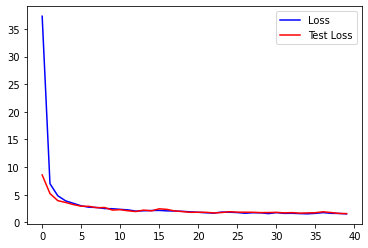

In [24]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

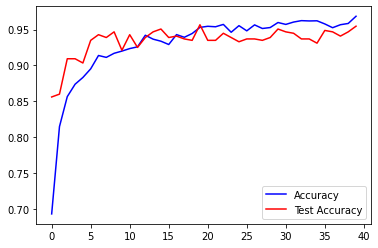

In [25]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

[1.9508777e-03 1.0854139e-03 3.8714192e-05 9.6440608e-06 9.9994507e+01
 4.8392827e-05 9.4744645e-04 1.3940952e-03 2.7920496e-05] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']
Prediction:  Other Plastics 99.99450445175171%


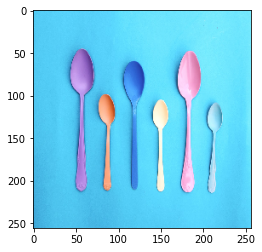

In [38]:
import requests

img_data = requests.get("https://images.unsplash.com/photo-1591872203534-278fc084969e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1064&q=80").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


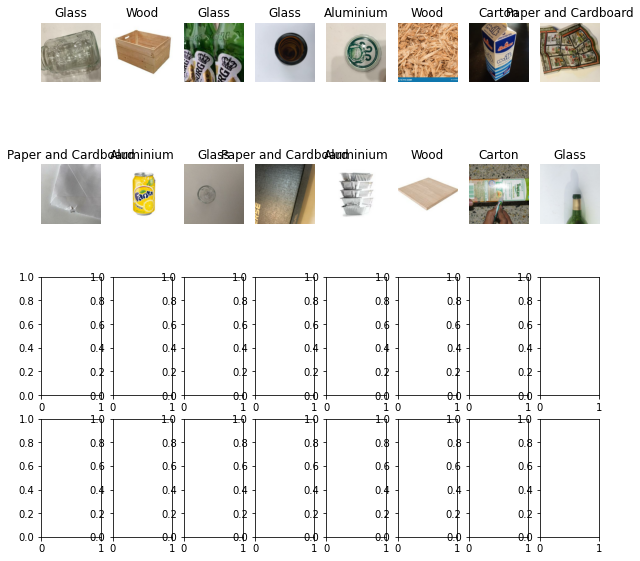

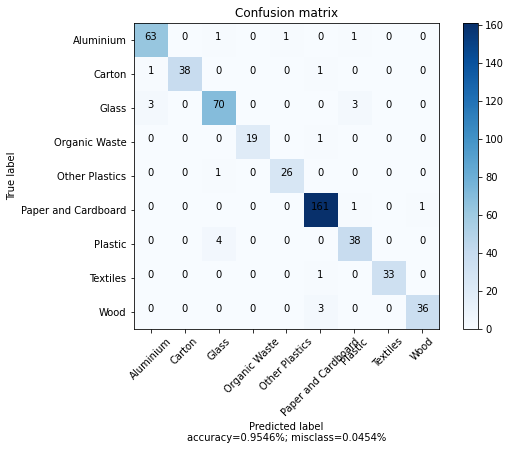

In [27]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""path = "/content/covid-classification-ml/Covid19_Dataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:1500]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
      #print(fullPath)
    except:
      print("Error on image:", fullPath)"""

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

**Advanced Filter Visualization**

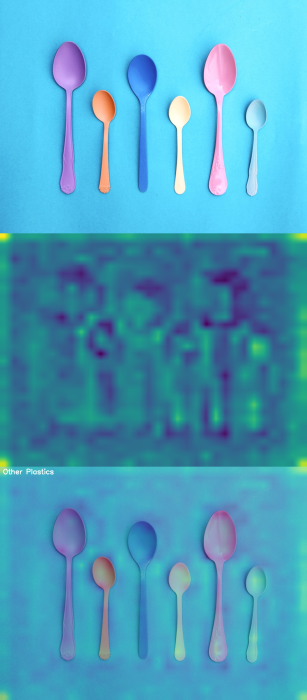

In [39]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import imutils

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()
   
  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return (heatmap, output)

path = "/content/img.jpg"
orig = cv2.imread(path)
resized = cv2.resize(orig, (256, 256))

image = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
cam = GradCAM(model, np.argmax(predictions[0]), "expanded_conv_6/expand")
heatmap = cv2.resize(cam.compute_heatmap(image), (orig.shape[1], orig.shape[0]))

#heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

#cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, classes[np.argmax(predictions)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)